## Primary Analysis

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns

from sklearn.ensemble import IsolationForest

import requests

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Step 1: Load the CSV files
df1 = pd.read_csv('transactions_1.csv')
df2 = pd.read_csv('transactions_2.csv')
df1.rename(columns={'f0_': 'count'}, inplace=True) # Adjust the typos from tables

In [4]:
# Combine the two dataframes
df = pd.concat([df1, df2])

# Step 2: Calculate transaction statistics
transaction_stats = df.pivot_table(index='time', columns='status', values='count', aggfunc='sum').fillna(0).reset_index()
transaction_stats.head()

status,time,approved,backend_reversed,denied,failed,processing,refunded,reversed
0,00h 00,18.0,2.0,9.0,0.0,12.0,1.0,7.0
1,00h 01,29.0,1.0,20.0,0.0,2.0,0.0,2.0
2,00h 02,16.0,3.0,11.0,0.0,5.0,1.0,5.0
3,00h 03,18.0,2.0,5.0,0.0,4.0,0.0,9.0
4,00h 04,23.0,3.0,4.0,0.0,2.0,0.0,10.0


In [6]:
# convert time from string to float
data = transaction_stats
data['time'] = data['time'].str.replace('h', '').str.replace(' ', '').astype(float)*0.01
data.tail()

status,time,approved,backend_reversed,denied,failed,processing,refunded,reversed
1400,23.55,63.0,0.0,12.0,0.0,0.0,0.0,0.0
1401,23.56,64.0,0.0,11.0,0.0,0.0,0.0,0.0
1402,23.57,61.0,0.0,15.0,0.0,0.0,0.0,1.0
1403,23.58,46.0,4.0,7.0,0.0,3.0,1.0,2.0
1404,23.59,48.0,5.0,11.0,0.0,4.0,0.0,6.0


In [11]:
data['total_resversed'] = data['backend_reversed'] + data['reversed']
data.tail()

status,time,approved,backend_reversed,denied,failed,processing,refunded,reversed,total_resversed
1400,23.55,63.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
1401,23.56,64.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0
1402,23.57,61.0,0.0,15.0,0.0,0.0,0.0,1.0,1.0
1403,23.58,46.0,4.0,7.0,0.0,3.0,1.0,2.0,6.0
1404,23.59,48.0,5.0,11.0,0.0,4.0,0.0,6.0,11.0


### Finding Anomalous Valous Using Machine Learning


#### Transactions to analyze:
- Failed Transactions
- Reversed Transactions
- Denied Transactions

In [16]:
# create method to identify anomalies:
def anomaly_identifier(data, type_of_transaction):
    df = data[['time', type_of_transaction]] #reduce the analysis to only 1 type of transaction per time
    model = IsolationForest(contamination=0.1, random_state=42) #consider 10% outliers
    model.fit(df)
    df['anomaly_scores'] = model.decision_function(df)
    df['anomaly'] = model.predict(df[['time', type_of_transaction]])
    
    return df

In [17]:
df_reversed = anomaly_identifier(data, 'total_resversed')

In [19]:
df_fails = anomaly_identifier(data, 'failed')

In [20]:
df_denied = anomaly_identifier(data, 'denied')

In [48]:
df_denied.head()

status,time,denied,anomaly_scores,anomaly
0,0.00,9.0,-0.078304,-1
1,0.01,20.0,-0.120887,-1
2,0.02,11.0,-0.082977,-1
3,0.03,5.0,-0.040087,-1
4,0.04,4.0,-0.031789,-1


In [22]:
print(f'Total of Anomalous Denied Values: {len(df_denied[df_denied["anomaly"] == -1])}')

Total of Anomalous Denied Values: 141


### Plotting the data:

In [23]:
def anomalies_plot(data, anomaly_method_name, x_var, y_var, xaxis_limit=[0,1], yaxis_limit=[0,1]):
    print(f'Anomaly Method: {anomaly_method_name}')
    
    method = f'{anomaly_method_name}_anomaly'
    
    print(f"Number of anomalous values: {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values: {len(data[data['anomaly']==1])}")
    print(f"Total Number of Values: {len(data)}")
    
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Anomaly Method: {anomaly_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limit, ylim=yaxis_limit)
    axes = g.axes.flatten()
    axes[0].set_title(f'Anomalous Values\n{len(data[data["anomaly"] == -1])} points')
    axes[1].set_title(f'Non Anomalous Values\n{len(data[data["anomaly"] == 1])} points')
    return g

Anomaly Method: Isolation Forest - Denied Transactions
Number of anomalous values: 141
Number of non anomalous values: 1264
Total Number of Values: 1405


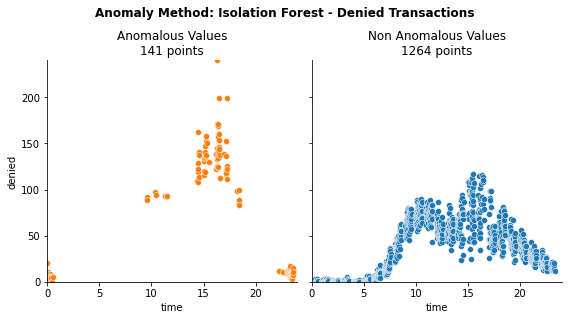

In [27]:
anomalies_plot(df_denied, 'Isolation Forest - Denied Transactions', 'time', 'denied', [0,24], [0,np.max(df_denied['denied'])])

Anomaly Method: Isolation Forest - Reversed Transactions
Number of anomalous values: 141
Number of non anomalous values: 1264
Total Number of Values: 1405


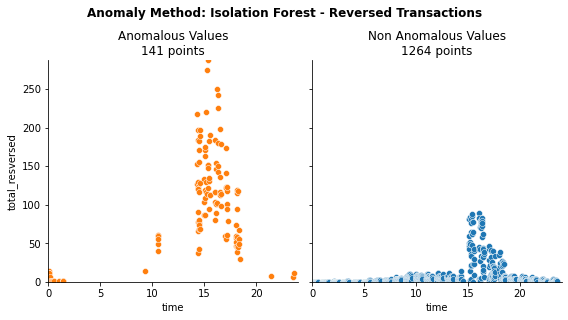

In [32]:
anomalies_plot(df_reversed, 'Isolation Forest - Reversed Transactions', 'time', 'total_resversed',\
               [0,24], [0,np.max(df_reversed['total_resversed'])])

Anomaly Method: Isolation Forest - Failed Transactions
Number of anomalous values: 141
Number of non anomalous values: 1264
Total Number of Values: 1405


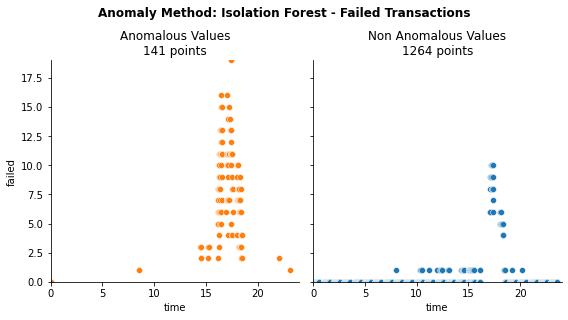

In [31]:
anomalies_plot(df_fails, 'Isolation Forest - Failed Transactions', 'time', 'failed', [0,24], [0,np.max(df_fails['failed'])])

## Implementation of Monitoring Alert System:

In [ ]:
def monitoring_system():
    # first step: receive the new data from new transactions(in this case i will assume we can access this data via API)
    URL = '<URL-HERE>'
    API_KEY = '<API-KEY-HERE>'

    headers = {
    'Accept': 'application/json',
    'Authorization': 'Bearer ' + API_KEY,
    }
    
    new_data = requests.get(URL, headers=headers).json()
    # concatenate new data to database (assuming this data has a unique id to distinct them)
    df['id'] = df.index
    for data in new_data['data']:
        #if we could order the response from API by most recents we could add a 'break' condition after the first data repeated
        if data['id'] not in df['id']:
            new_data_dict = {
                'time': data['time'],
                'status': data['status'],
                'count': data['count'],
                'id': data['id']
            }
            new_df = pd.DataFrame(new_data_dict, index=[0])
    df = pd.concat([df, new_df])
    # now we drop the past values to mantain the lenght of the dataframe
    df3 = df.drop(df.index[:len(new_data_dict)/4])
    transaction_stats = df3.pivot_table(index='time', columns='status', values='count', aggfunc='sum').fillna(0).reset_index()
    # convert time from string to float
    data = transaction_stats
    data['time'] = data['time'].str.replace('h', '').str.replace(' ', '').astype(float)*0.01
    data['total_reversed'] = data['backend_reversed'] + data['reversed']
    df_fails = anomaly_identifier(data, 'failed')
    df_denied = anomaly_identifier(data, 'denied')
    df_reversed = anomaly_identifier(data, 'total_reversed')
    # plot the data
    anomalies_plot(df_denied, 'Isolation Forest - Denied Transactions',\
                                 'time', 'denied', [0,24], [0,np.max(df_denied['denied'])])
    
    anomalies_plot(df_fails, 'Isolation Forest - Failed Transactions',\
                                'time', 'failed', [0,24], [0,np.max(df_fails['failed'])])
    
    anomalies_plot(df_reversed, 'Isolation Forest - Reversed Transactions',\
                                   'time', 'total_resversed',\
               [0,24], [0,np.max(df_reversed['total_resversed'])])
    
    # report the new anomalies:
    for index, row in new_df.iterrows():
        transaction_id = row['id']
        if row['status'] == 'denied':
            if df_denied.loc[df_denied['id'] == transaction_id, 'anomaly'] == -1:
                print('Denied Transaction above normal')
        elif row['status'] == 'failed': 
            if df_denied.loc[df_denied['id'] == transaction_id, 'anomaly'] == -1:
                print('Failed Transaction above normal')
        elif row['status'] == 'reversed' or 'backend_reversed':
            if df_denied.loc[df_denied['id'] == transaction_id, 'anomaly'] == -1:
                print('Reversed Transaction above normal')